In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr
!pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 59.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.0
    Uninstalling transformers-4.44.0:
      Successfully uninstalled transformers-4.44.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.21.0
    Uninstalling datasets-2.21.0:
      Successfully uninstalled datasets-2.21.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0

In [3]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [4]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [5]:
samsum = load_dataset('samsum')
samsum

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

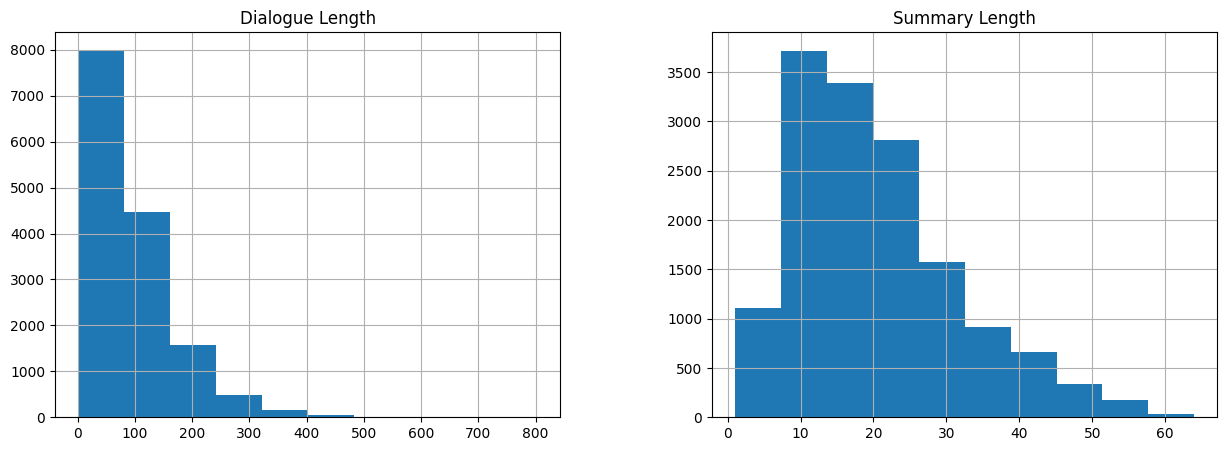

In [6]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))
     

In [7]:
def preprocessing(batch):
    encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

    encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

    return encodings


samsum_pt = samsum.map(preprocessing, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [8]:
samsum_pt=samsum_pt.remove_columns(['dialogue', 'summary'])

In [9]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [10]:
from transformers import DataCollatorForSeq2Seq
from evaluate import load
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predictions
    predictions = tokenizer.batch_decode(logits, skip_special_tokens=True)
    # Convert labels to references
    references = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = load("rouge")

    return rouge.compute(predictions=predictions, references=references)

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

In [14]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=153, training_loss=1.5378658132615433, metrics={'train_runtime': 1263.641, 'train_samples_per_second': 11.658, 'train_steps_per_second': 0.121, 'total_flos': 1.0045659941978112e+16, 'train_loss': 1.5378658132615433, 'epoch': 0.996742671009772})

In [15]:
trainer.save_model('bart_samsum_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [16]:
!zip bart_samsum.zip -r bart_samsum_model/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: bart_samsum_model/ (stored 0%)
  adding: bart_samsum_model/tokenizer_config.json (deflated 75%)
  adding: bart_samsum_model/generation_config.json (deflated 48%)
  adding: bart_samsum_model/merges.txt (deflated 53%)
  adding: bart_samsum_model/training_args.bin (deflated 51%)
  adding: bart_samsum_model/vocab.json (deflated 59%)
  adding: bart_samsum_model/special_tokens_map.json (deflated 52%)
  adding: bart_samsum_model/config.json (deflated 61%)
  adding: bart_samsum_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_model/model.safetensors (deflated 7%)


In [17]:
from transformers import pipeline

In [18]:

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [21]:
custom_dialogue="""
Raj: What are your thoughts on assigning work to Priya? Anita: I’m thinking of giving her the new client presentation to handle first. Raj: Sounds good. Do you think she’s ready for it? Anita: She performed well in the recent tasks. I’ll give her a new assignment after she completes this one.
"""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 128, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


[{'summary_text': ". Anita will give Priya the new client presentation to handle first. She will give her a new assignment after she completes this one. She performed well in the recent tasks. She is ready for the new assignment. She's ready for it. She’s ready."}]


In [1]:
import torch
print(torch.__version__)


2.4.0+cpu
